## Advanced ML: Домашнее задание 1

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

large = 18
med = 14
small = 12
params = {
    #"axes.titlesize": large,
    "figure.titlesize": large,
    "legend.fontsize": med,
    "figure.figsize": (24, 6),
    "axes.labelsize": med,
    "axes.titlesize": med,
    "xtick.labelsize": small,
    "ytick.labelsize": small,
    
}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")

### 1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [2]:
# url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# data = pd.read_csv(url)
data = pd.read_csv("data/owid-covid-data.csv")
data = data.loc[(data["iso_code"] == "RUS"), ["date", "total_cases", "new_cases"]]
data["date"] = pd.to_datetime(data["date"])
data = data.loc[(data["date"] >= pd.to_datetime("2020-03-03")), :].reset_index(drop=True)
data.loc[data["new_cases"] == 0, "new_cases"] = 1
data.head()

,date,total_cases,new_cases
0,2020-03-03,3.0,1.0
1,2020-03-04,3.0,1.0
2,2020-03-05,4.0,1.0
3,2020-03-06,13.0,9.0
4,2020-03-07,13.0,1.0


Используя все доступные данные, посмотрим на динамику распространения СOVID:

Text(0, 0.5, 'New cases')

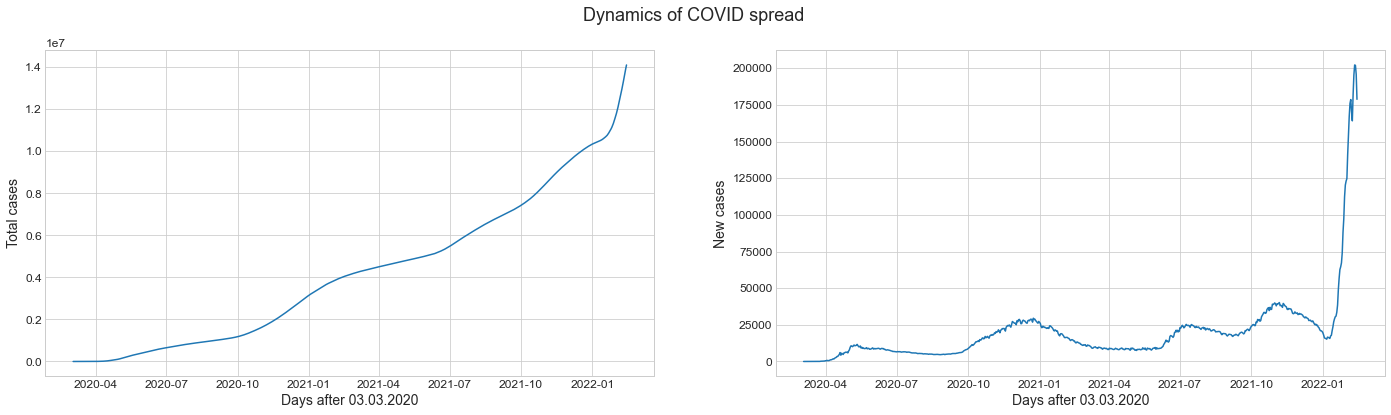

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(data["date"], data["total_cases"], color="tab:blue")
ax2.plot(data["date"], data["new_cases"], color="tab:blue")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases")

In [4]:
x_train, x_test = data[:50], data[50:]
train_days = x_train.index.values.reshape(-1, 1)
days = data.index.values.reshape(-1, 1)

### 2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

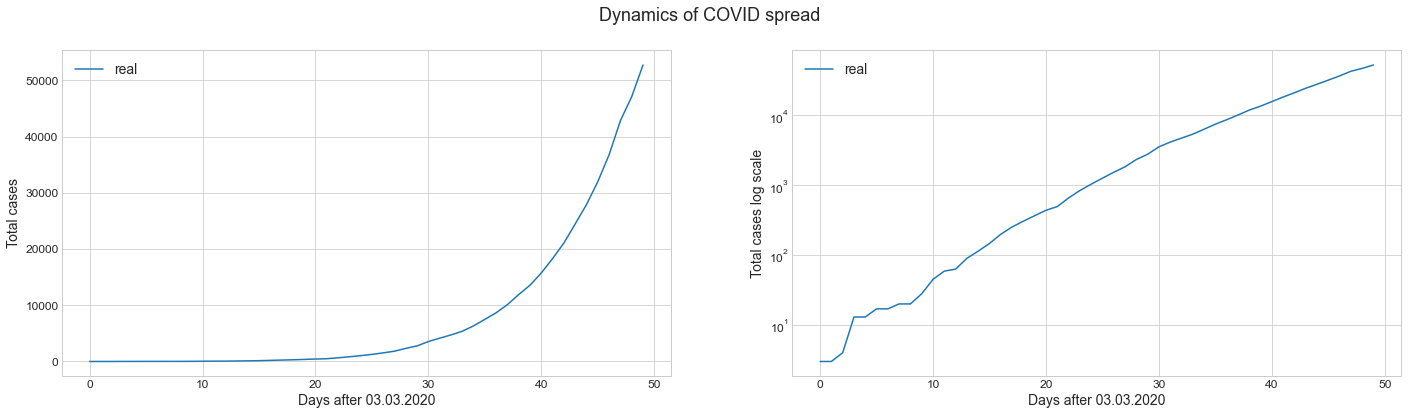

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()


#### 2.1. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
$$y \sim \exp(b+wX)$$
$$\ln(\bar y) = b+wX$$

In [6]:
model = linear_model.LinearRegression()
model.fit(train_days, np.log(x_train["total_cases"]))
x_train["total_cases_ln_pred"] = model.predict(train_days)
x_train["total_cases_exp_pred"] = np.exp(x_train["total_cases_ln_pred"])

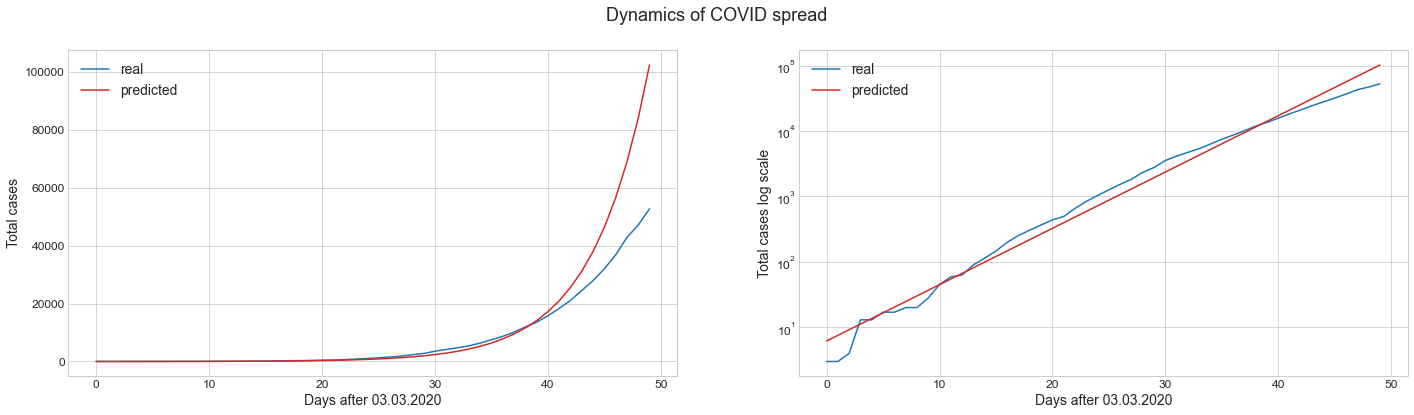

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, x_train["total_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, x_train["total_cases_exp_pred"], color="tab:red", label="predicted")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

#### 2.2. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

В байесовском подходе ищут:
1. **апостериорное распределение (posterior)**: $$p(\theta|D) \propto p(D|\theta)p(\theta)$$
2.  **максимальную апостериорную гипотезу** (**MAP - maximum a posteriori**) $$\theta_{MAP}=\underset{\theta}{\mathrm{argmax}}\, p(\theta|D)=\underset{\theta}{\mathrm{argmax}}\,p(D|\theta)p(\theta)=\underset{\theta}{\mathrm{argmax}}\, \left(\mathrm{log}\,p(\theta)+\sum_{d \in D}\mathrm{log}\,p(d|\theta)\right)$$

Для нахождения постериорного распределения параметров необходимо найти правдоподобие $p(D|\theta)$ и выбрать априорное распределение $p(\theta)$.
$$p(D|\theta) = \prod_{i=1}^{N} p(y_n|\theta x_n) = \prod_{i=1}^{N} \mathcal{N} (y_n|\theta x_n, \sigma^2) = \prod_{i=1}^{N} \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(y - b - wx_i)^2}{2\sigma^2}}$$
Дисперсия шума:
$$\sigma^2 = \frac{1}{N}\sum\limits_{i=1}^N\ln(y_i) - \ln(\bar y_i) = \frac{1}{N}\sum\limits_{i=1}^N\ln(y_i) - (b+wx_i) $$


Aприорное распределение параметров $p(\theta)$ зададим как двухмерное нормальное распределение.


In [8]:
def calculate_likehood(x, y, w, bias, sigma_noise):
    return np.prod(np.exp(-np.power(y - bias - w*x, 2) / (2 * sigma_noise**2)) / np.sqrt(2 * np.pi * sigma_noise**2))

In [9]:
w = model.coef_[0]
bias = model.intercept_

sigma_noise = np.sqrt(((np.log(x_train["total_cases"].values) - bias - w*train_days.reshape(1, -1)) ** 2).mean())

In [10]:
sigma_noise

0.34904220596356583

In [11]:
w

0.19829091233588567

**Априорное распределение параметров модели:**

Text(0, 0.5, 'bias')

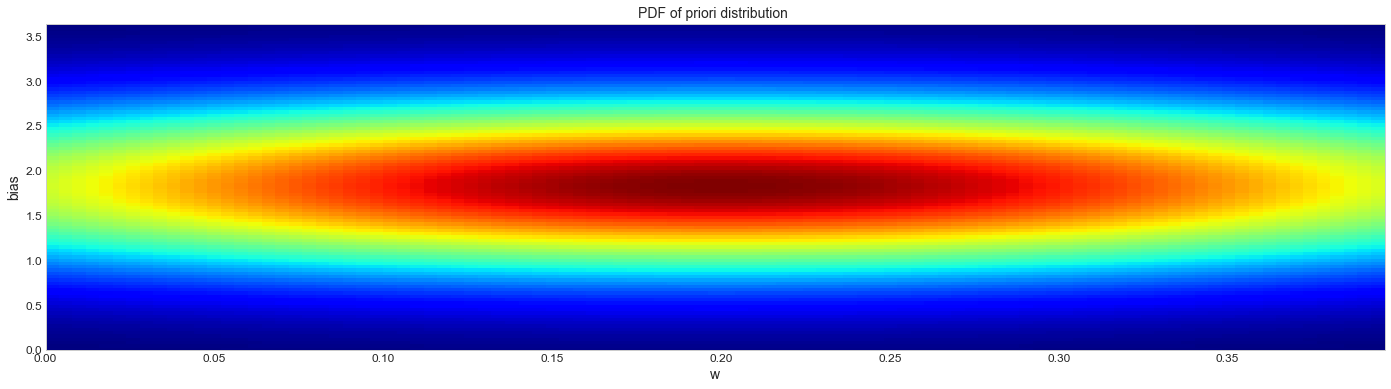

In [12]:
w_x = np.linspace(w-w, w+w, 100)
bias_y = np.linspace(bias-bias, bias+bias, 100)
w_xx, bias_yy = np.meshgrid(w_x, bias_y)
pos = np.dstack((w_xx, bias_yy))
priori = multivariate_normal([w, bias], [[w/5, 0], [0, bias/4]])
plt.pcolormesh(w_xx, bias_yy, priori.pdf(pos), cmap="jet")
plt.title("PDF of priori distribution ")
plt.xlabel("w")
plt.ylabel("bias")

**Правдоподобие параметров модели:**

Text(0, 0.5, 'bias')

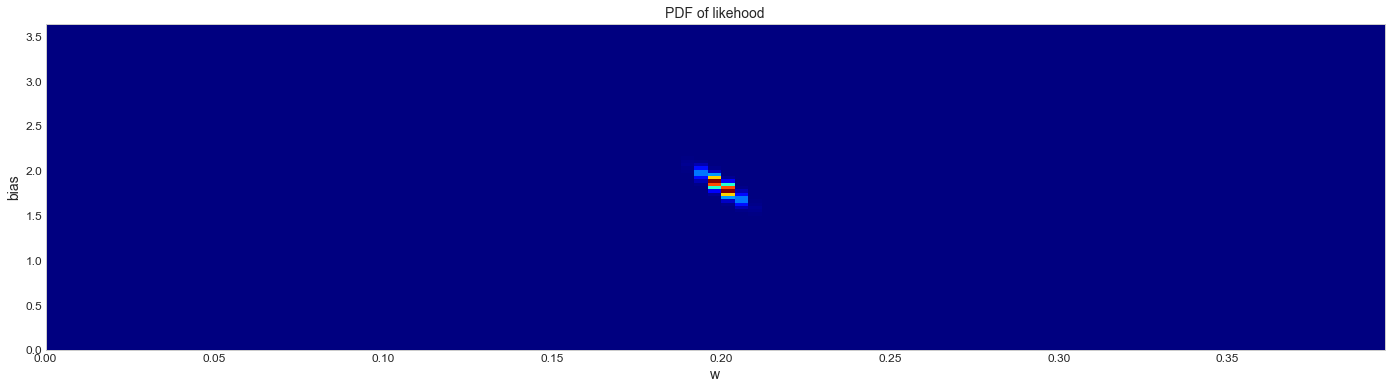

In [13]:
likehood = np.zeros(w_xx.shape)
for x in range(w_xx.shape[0]):
    for y in range(w_xx.shape[1]):
        likehood[x, y] = calculate_likehood(x_train.index, np.log(x_train["total_cases"]), w_xx[x, y], bias_yy[x, y], sigma_noise)
plt.pcolormesh(w_xx, bias_yy, likehood, cmap="jet")
plt.title("PDF of likehood")
plt.xlabel("w")
plt.ylabel("bias")

**Апостериорное распределение параметров модели:**

Text(0, 0.5, 'bias')

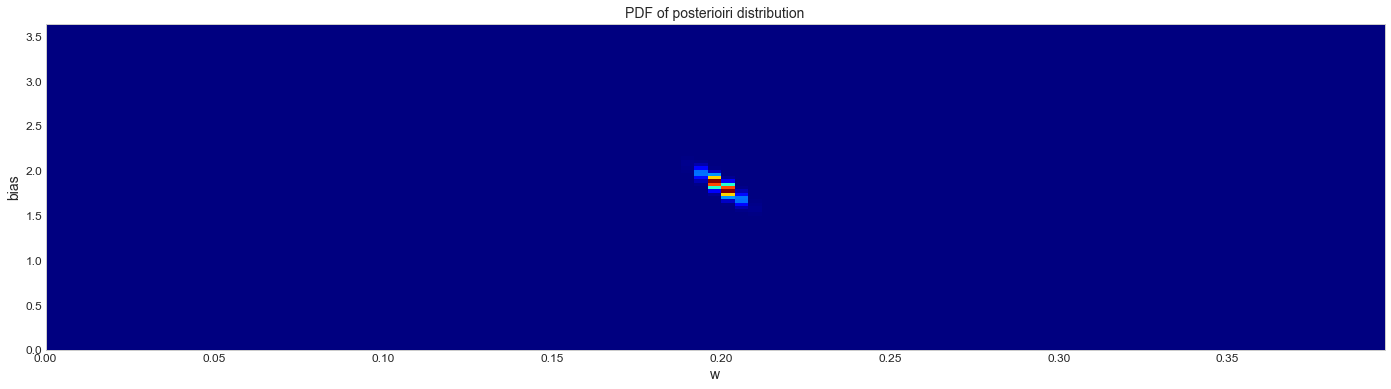

In [14]:
posterioiri_pdf = priori.pdf(pos)*likehood
plt.pcolormesh(w_xx, bias_yy, posterioiri_pdf, cmap="jet")
plt.title("PDF of posterioiri distribution")
plt.xlabel("w")
plt.ylabel("bias")

**Параметры соответсвующие максимуму априорного распределения (MAP):**

In [15]:
map_x, map_y = np.unravel_index(posterioiri_pdf.argmax(), posterioiri_pdf.shape)
w_map = w_xx[map_x, map_y]
bias_map = bias_yy[map_x, map_y]

#### 2.3. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

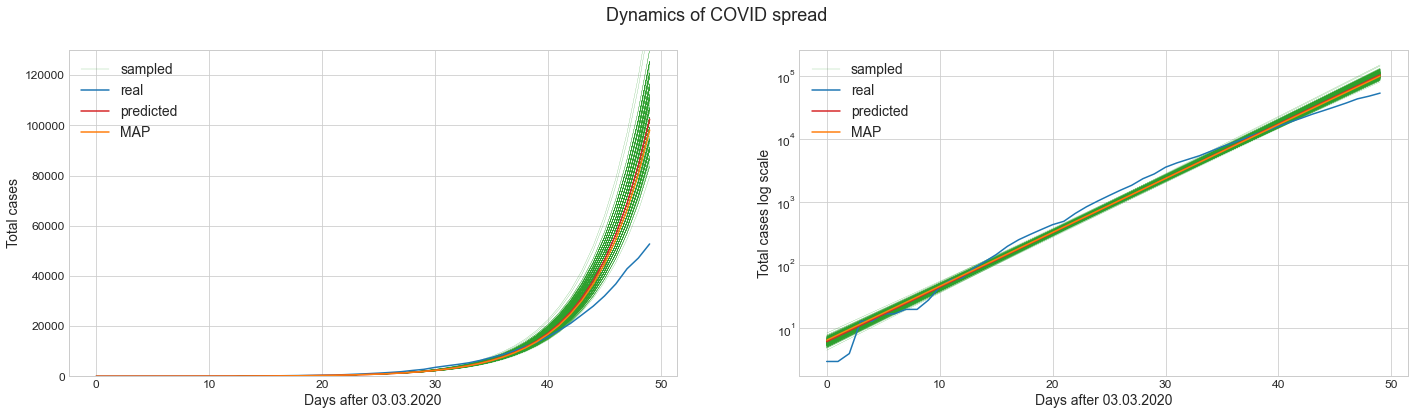

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(train_days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*train_days), color="tab:green", lw=0.2)
    ax2.plot(train_days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*train_days), color="tab:green", lw=0.2)

sample_x, sample_y = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(train_days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*train_days), color="tab:green", label="sampled", lw=0.2)
ax2.plot(train_days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*train_days), color="tab:green", label="sampled", lw=0.2)

ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, x_train["total_cases_exp_pred"], color="tab:red", label="predicted")
ax1.plot(train_days, np.exp(bias_map + w_map*train_days), color="tab:orange", label="MAP")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, x_train["total_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(train_days, np.exp(bias_map + w_map*train_days), color="tab:orange", label="MAP")
fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.set_ylim(0, 130000)
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

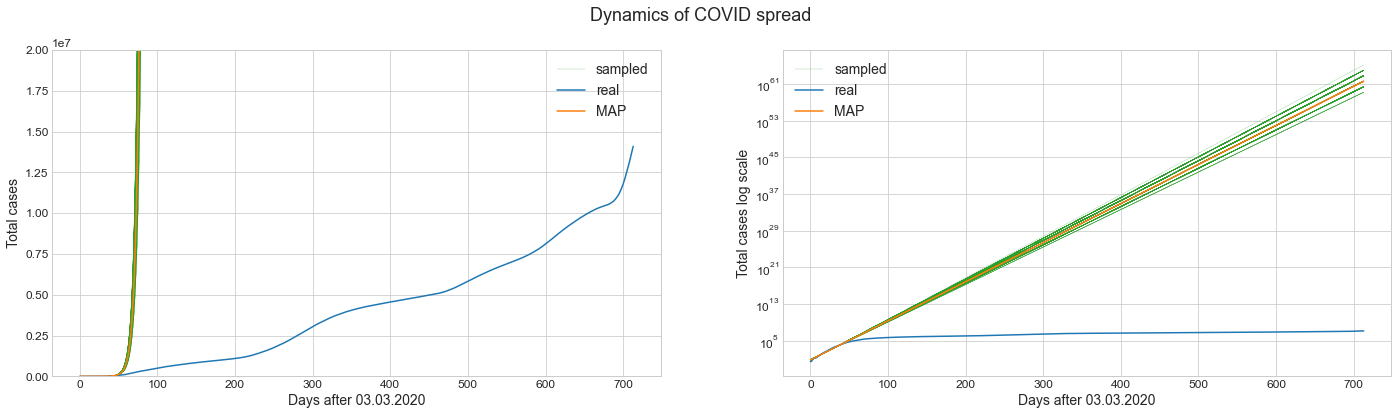

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
for _ in range(1000):
    sample_x, sample_y = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*days), color="tab:green", lw=0.2)
    ax2.plot(days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*days), color="tab:green", lw=0.2)

sample_x, sample_y = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*days), color="tab:green", label="sampled", lw=0.2)
ax2.plot(days, np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*days), color="tab:green", label="sampled", lw=0.2)

ax1.plot(days, data["total_cases"], color="tab:blue", label="real")
ax1.plot(days, np.exp(bias_map + w_map*days), color="tab:orange", label="MAP")
ax2.plot(days, data["total_cases"], color="tab:blue", label="real")
ax2.plot(days, np.exp(bias_map + w_map*days), color="tab:orange", label="MAP")
fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.set_ylim(0, 20000000)
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

**Предсказательные распределения:**

Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:
    на 01.05.2020: 698647
    на 01.07.2020: 306837437
    на 01.09.2020: 21360551722468584

Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:
    на 01.05.2020: 751981
    на 01.07.2020: 342635018
    на 01.09.2020: 23852607713484060



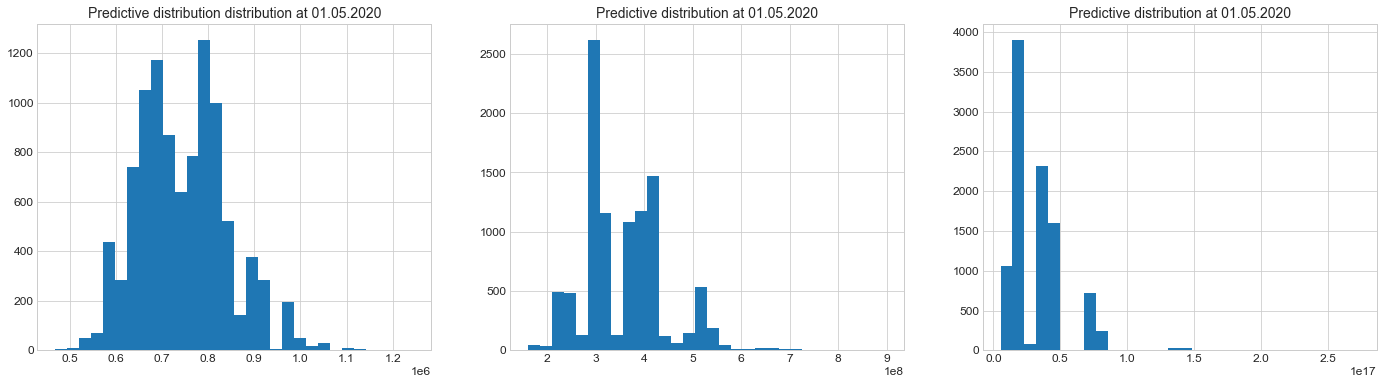

In [19]:
n_sampels = 10000
posterior_samples = np.ones([n_sampels, data.shape[0]])
for i in range(n_sampels):
    sample_x, sample_y = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    posterior_samples[i] = np.exp(bias_yy[sample_x, sample_y] + w_xx[sample_x, sample_y]*days.reshape(1, -1))

may_day = data[data["date"] == "2020-05-01"].index[0]
june_day = data[data["date"] == "2020-06-01"].index[0]
sep_day = data[data["date"] == "2020-09-01"].index[0]

fig, ax = plt.subplots(1, 3)

ax[0].hist(posterior_samples[:, may_day], bins=30)
ax[0].set_title("Predictive distribution distribution at 01.05.2020")


ax[1].hist(posterior_samples[:, june_day], bins=30)
ax[1].set_title("Predictive distribution at 01.05.2020")

ax[2].hist(posterior_samples[:, sep_day], bins=30)
ax[2].set_title("Predictive distribution at 01.05.2020")

total_cases_map = np.exp(bias_map + w_map*days)
print(f"Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:\n\
    на 01.05.2020: {int(total_cases_map[may_day][0])}\n\
    на 01.07.2020: {int(total_cases_map[june_day][0])}\n\
    на 01.09.2020: {int(total_cases_map[sep_day][0])}\n")

total_cases_map = np.exp(bias_map + w_map*days)
print(f"Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:\n\
    на 01.05.2020: {int(np.median(posterior_samples[:, may_day]))}\n\
    на 01.07.2020: {int(np.median(posterior_samples[:, june_day]))}\n\
    на 01.09.2020: {int(np.median(posterior_samples[:, sep_day]))}\n")

**Вывод:** Согласно предсказаний экспоненциальной модели уже к 1 июня переболее более 300 млн россиян, при том что всего в России около 140 млн жителей. Можно сделать вывод, что экспоненциальная модель не подходит для прогнозирования динамиик развития эпидемий.

### 3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
$$\Phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\inf}^{\inf}e^{-\frac{t^2}{2}}\, dt$$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

Для лучшего понимания, изобразим график сигмоиды от квадратичной функции:

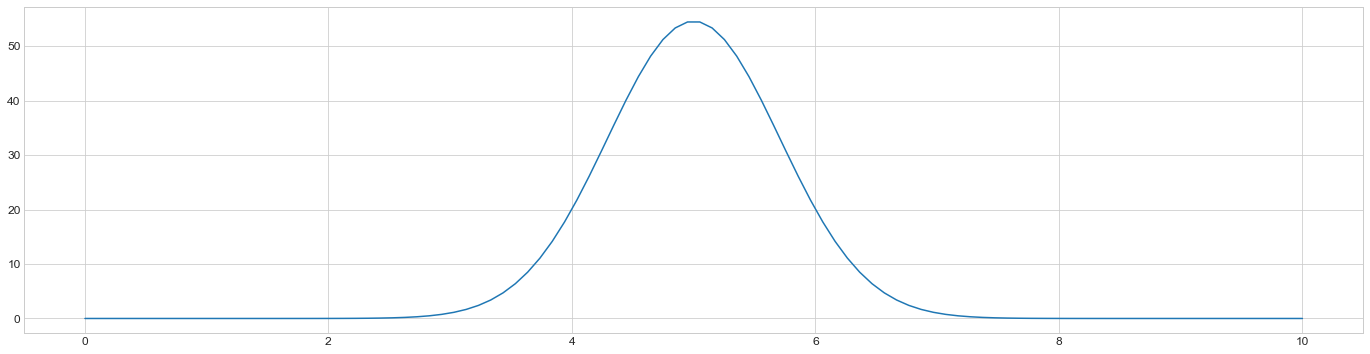

In [20]:
t = np.linspace(0, 10, 100)
plt.plot(t, np.exp(-(t**2-10*t+21)))

В контексте развития эпидемии, такая зависисмость может описывать число новых случаев, которые фиксируются за определённый период времени (день, неделю), сначала идёт рост новых случаев, потом достигается пик, и количество новых случаев идёт на спад.

#### 3.1. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Будем обучать параметры сигмоидальной функции на данных числа новых случаев зафиксированных за сутки. Будем использовать полученную функцию для анализа общего числа случаев.
$$\bar y_{new\,cases} = exp(w_0+w_1x+w_2x^2)$$
$$\ln\bar y_{new\,cases} = w_0+w_1x+w_2x^2$$

In [11]:
x_train_poly = np.hstack([np.ones(train_days.shape), train_days, train_days ** 2])
days_poly = np.hstack([np.ones(days.shape), days, days ** 2])
y_train = np.log(x_train["new_cases"])

new_cases_model = linear_model.LinearRegression(fit_intercept=False).fit(x_train_poly, y_train)

x_train["new_cases_exp_pred"] = np.exp(new_cases_model.predict(x_train_poly))

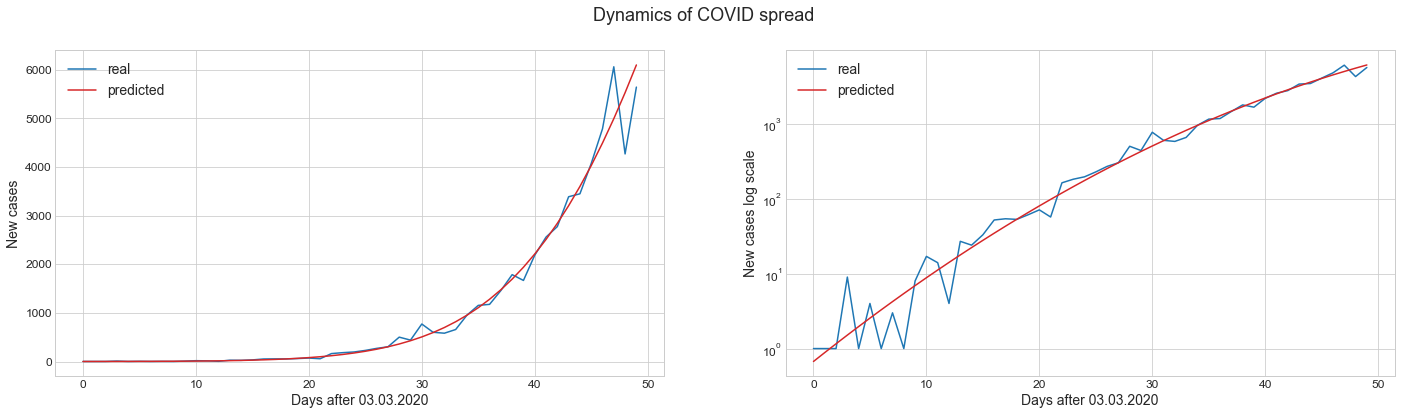

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_train.index, x_train["new_cases"], color="tab:blue", label="real")
ax1.plot(x_train.index, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(x_train.index, x_train["new_cases"], color="tab:blue", label="real")
ax2.plot(x_train.index, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("New cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases log scale")
ax2.set_yscale("log")
ax2.legend()

Предскзания модели неплохо согласуются с числом новых случаев в период первых 50 дней эпидемии. Посмотрим на общее количество случаев посчитанное как кумулятивная сумма от предсказаний.

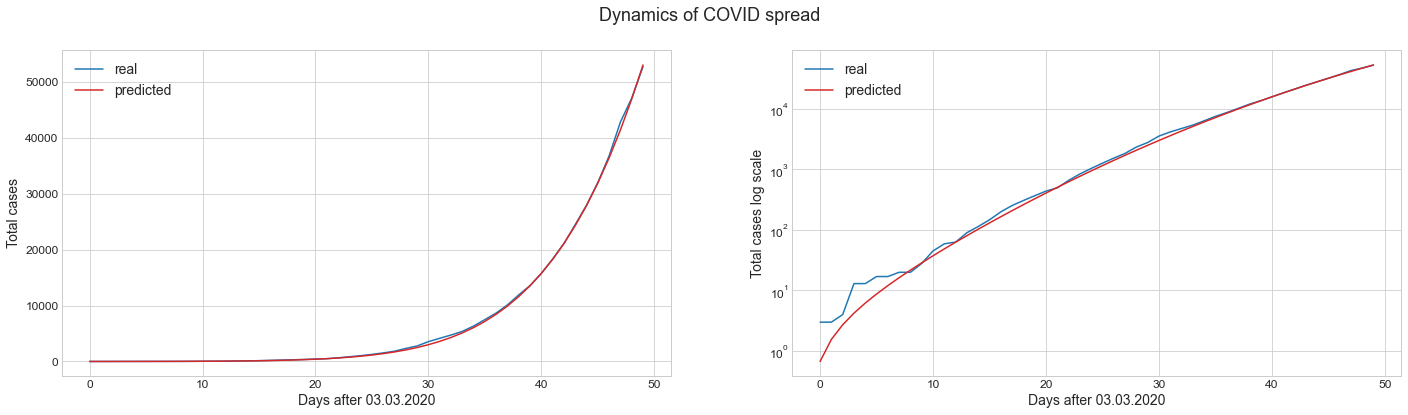

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

#### 3.2. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [14]:
def calculate_likehood_poly(x, y, w, sigma_noise):
    return np.prod(np.exp(-np.power(y - x @ w, 2) / (2 * sigma_noise**2)) / np.sqrt(2 * np.pi * sigma_noise**2))

In [15]:
w = new_cases_model.coef_

sigma_noise = np.sqrt(((np.log(x_train["new_cases"].values) - x_train_poly @ w) ** 2).mean())

In [16]:
sigma_noise

0.4891695424595195

**Априорное распределение параметров модели:**

In [27]:
w0_x = np.linspace(w[0]+w[0]/2, w[0]-w[0]/2, 100)
w1_y = np.linspace(w[1]-w[1]/2, w[1]+w[1]/2, 100)
w2_z = np.linspace(w[2]+w[2]/2, w[2]-w[2]/2, 100)

w0_xx, w1_yy, w2_zz = np.meshgrid(w0_x, w1_y, w2_z, indexing='ij')
pos = np.dstack((w0_xx, w1_yy, w2_zz))
priori = multivariate_normal(w, [[np.abs(w[0])/4, 0, 0], [0, np.abs(w[1])/4, 0], [0, 0, np.abs(w[2])/4]])

**Правдоподобие параметров модели:**

In [28]:
likehood = np.zeros(w0_xx.shape)
for x in range(w0_xx.shape[0]):
    for y in range(w0_xx.shape[1]):
        for z in range(w0_xx.shape[2]):
            likehood[x, y, z] = calculate_likehood_poly(x_train_poly, np.log(x_train["new_cases"]), np.array([w0_xx[x, y, z], w1_yy[x, y, z], w2_zz[x, y, z]]), sigma_noise)

In [29]:
pos = np.empty(w0_xx.shape + (3,))
pos[:, :, :, 0] = w0_xx
pos[:, :, :, 1] = w1_yy
pos[:, :, :, 2] = w2_zz

**Апостериорное распределение параметров модели:**

In [30]:
posterioiri_pdf = priori.pdf(pos)*likehood

**Параметры соответсвующие максимуму априорного распределения (MAP):**

In [31]:
map_x, map_y, map_z = np.unravel_index(posterioiri_pdf.argmax(), posterioiri_pdf.shape)
w_map = np.array([w0_xx[map_x, map_y, map_z], w1_yy[map_x, map_y, map_z], w2_zz[map_x, map_y, map_z]])

#### 3.3. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

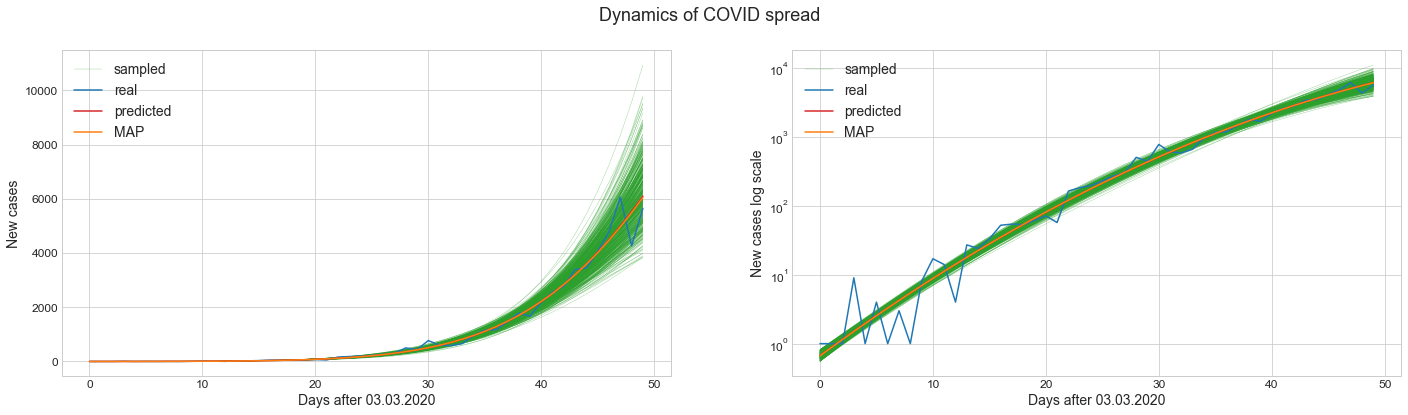

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", lw=0.2)
    ax2.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", label="sampled", lw=0.2)
ax2.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", label="sampled", lw=0.2)

ax1.plot(train_days, x_train["new_cases"], color="tab:blue", label="real")
ax1.plot(train_days, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax1.plot(train_days, np.exp(x_train_poly @ w_map), color="tab:orange", label="MAP")
ax2.plot(train_days, x_train["new_cases"], color="tab:blue", label="real")
ax2.plot(train_days, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(train_days, np.exp(x_train_poly @ w_map), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("New cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases log scale")
ax2.set_yscale("log")
ax2.legend()

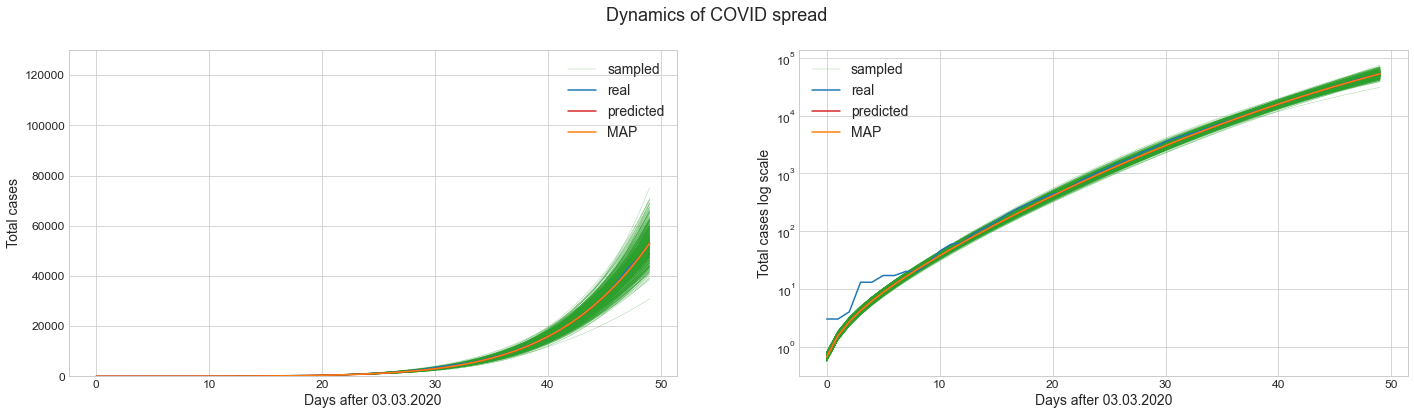

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)
    ax2.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)
ax2.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)

ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax1.plot(train_days, np.cumsum(np.exp(x_train_poly @ w_map)), color="tab:orange", label="MAP")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax2.plot(train_days, np.cumsum(np.exp(x_train_poly @ w_map)), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.set_ylim(0, 130000)
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

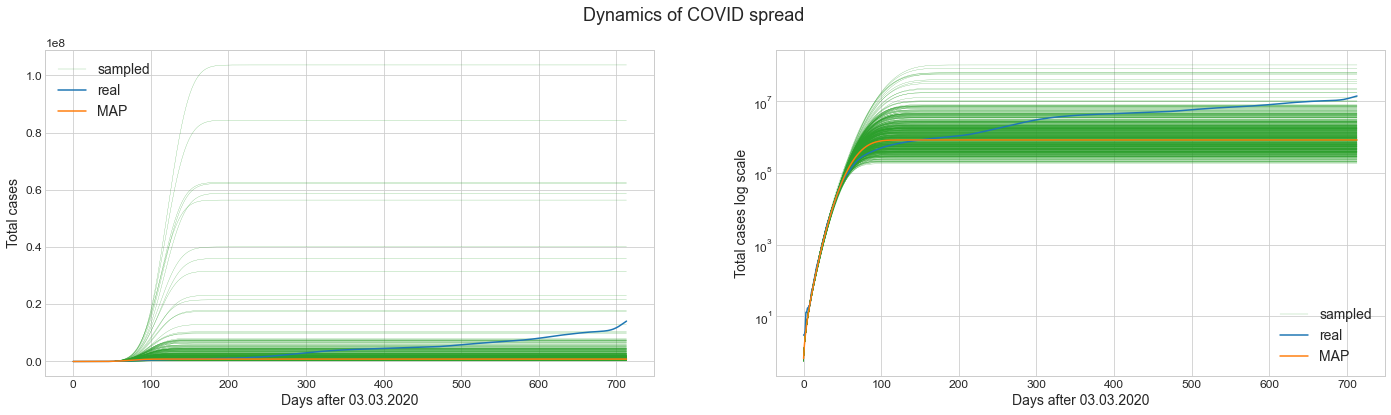

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)
    ax2.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)
ax2.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)

ax1.plot(days, data["total_cases"], color="tab:blue", label="real")
ax1.plot(days, np.cumsum(np.exp(days_poly @ w_map)), color="tab:orange", label="MAP")
ax2.plot(days, data["total_cases"], color="tab:blue", label="real")
ax2.plot(days, np.cumsum(np.exp(days_poly @ w_map)), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

**Предсказательные распределения:**

Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:
    на 01.05.2020: 150043.1826138642
    на 01.07.2020: 698584.2197721401
    на 01.09.2020: 837318.473215348

Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:
    на 01.05.2020: 152660.06125068455
    на 01.07.2020: 748719.6912121517
    на 01.09.2020: 920820.666734858



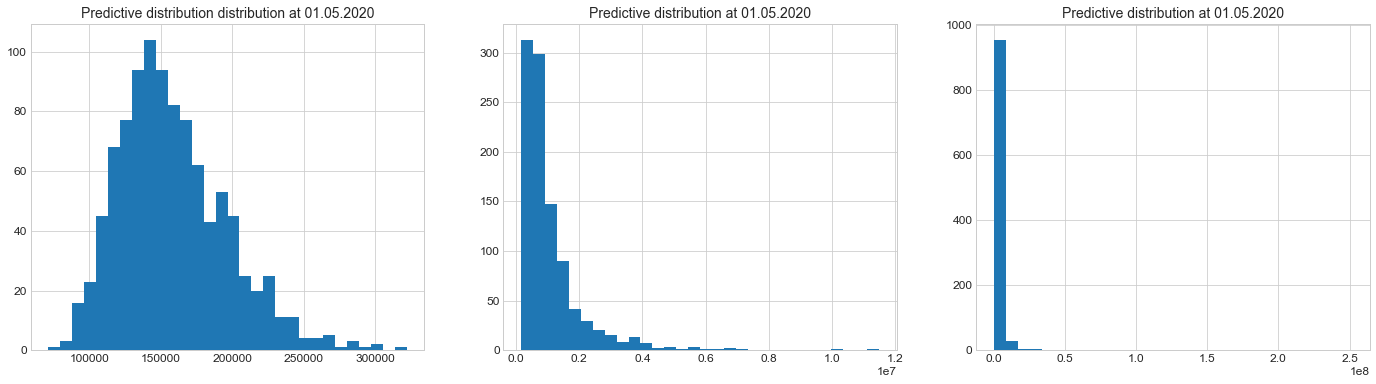

In [35]:
n_sampels = 1000
posterior_samples = np.ones([n_sampels, data.shape[0]])

for i in range(n_sampels):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    posterior_samples[i] = np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])))


fig, ax = plt.subplots(1, 3)

ax[0].hist(posterior_samples[:, may_day], bins=30)
ax[0].set_title("Predictive distribution distribution at 01.05.2020")


ax[1].hist(posterior_samples[:, june_day], bins=30)
ax[1].set_title("Predictive distribution at 01.05.2020")

ax[2].hist(posterior_samples[:, sep_day], bins=30)
ax[2].set_title("Predictive distribution at 01.05.2020")

total_cases_map = np.cumsum(np.exp(days_poly @ w_map))
print(f"Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:\n\
    на 01.05.2020: {total_cases_map[may_day]}\n\
    на 01.07.2020: {total_cases_map[june_day]}\n\
    на 01.09.2020: {total_cases_map[sep_day]}\n")

print(f"Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:\n\
    на 01.05.2020: {np.median(posterior_samples[:, may_day])}\n\
    на 01.07.2020: {np.median(posterior_samples[:, june_day])}\n\
    на 01.09.2020: {np.median(posterior_samples[:, sep_day])}\n")

In [52]:
last_date = data["date"].iloc[-1].date()
last_date_cases = data["total_cases"].iloc[-1]
print(f"Прогноз общего числа заболевших на {last_date}:\n\
    Оптимистичный: {int(np.quantile(posterior_samples[:, -1], 0.1))}\n\
    Пессимистичный: {int(np.quantile(posterior_samples[:, -1], 0.9))}\n\
    Крайне пессимистичный: {int(np.quantile(posterior_samples[:, -1], 0.98))}\n\
    Реальные данные: {int(last_date_cases)}\n")

Прогноз общего числа заболевших на 2022-02-14:
    Оптимистичный: 364733
    Пессиместичный: 4316660
    Крайне пессиместичный: 14847040
    Реальные данные: 14102736



**Вывод:** Полученные результаты выглядят более реалистичными. Исходя из кватилей, реальные данные соответсвуют крайне пессимистичный сценарий (98-й процентиль в выборке числа случаев).

### 4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

Для интереса посмотрим на Китай, который выделяется отсуствием новых волн корановирусной инфекции.

In [75]:
data = pd.read_csv("owid-covid-data.csv")
data = data.loc[(data["iso_code"] == "SWE"), ["date", "total_cases", "new_cases"]].reset_index(drop=True)
data["date"] = pd.to_datetime(data["date"])
data = data.loc[(data["date"] >= pd.to_datetime("2020-02-26")), :].reset_index(drop=True)
data = data.loc[data["new_cases"] > 0, :].fillna(0)
data.head()

,date,total_cases,new_cases
0,2020-02-26,2.0,1.0
1,2020-02-27,3.0,1.0
2,2020-02-28,11.0,8.0
3,2020-02-29,14.0,3.0
5,2020-03-02,19.0,5.0


Text(0, 0.5, 'New cases')

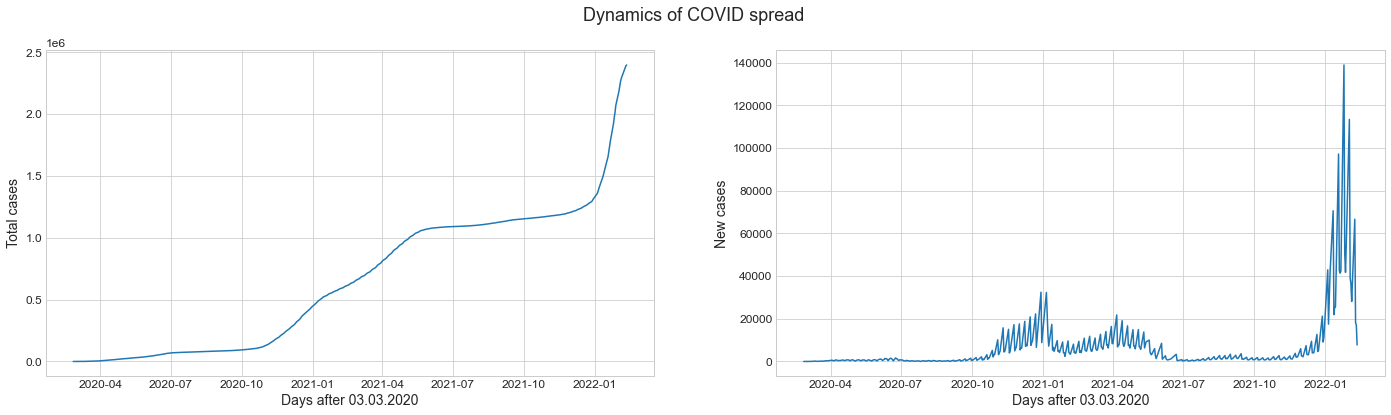

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(data["date"], data["total_cases"], color="tab:blue")
ax2.plot(data["date"], data["new_cases"], color="tab:blue")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases")

In [77]:
x_train, x_test = data[:50], data[50:]
train_days = x_train.index.values.reshape(-1, 1)
days = data.index.values.reshape(-1, 1)

#### 4.1 Обучение линейной регрессии.

In [78]:
x_train_poly = np.hstack([np.ones(train_days.shape), train_days, train_days ** 2])
days_poly = np.hstack([np.ones(days.shape), days, days ** 2])
y_train = np.log(x_train["new_cases"])

new_cases_model = linear_model.LinearRegression(fit_intercept=False).fit(x_train_poly, y_train)

x_train["new_cases_exp_pred"] = np.exp(new_cases_model.predict(x_train_poly))

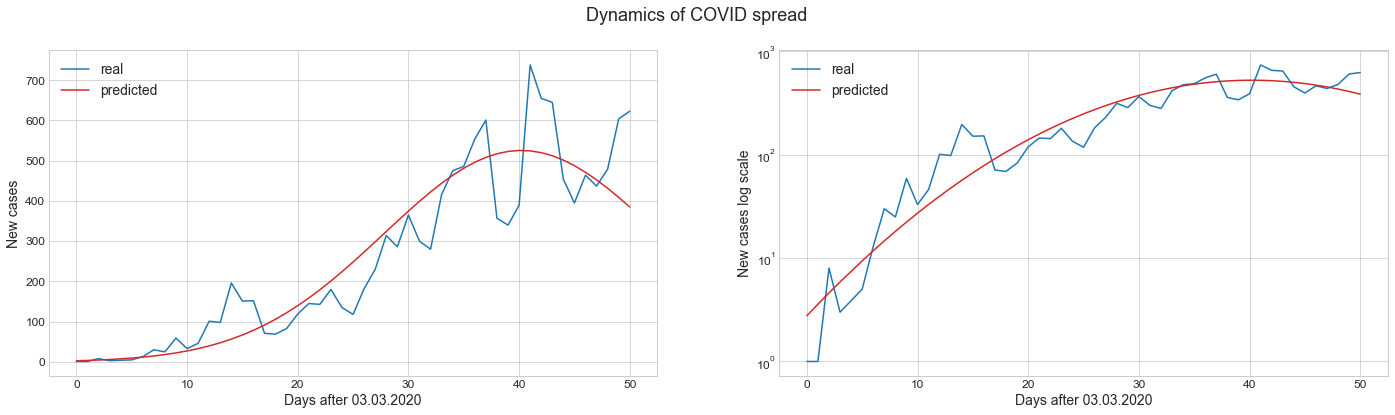

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_train.index, x_train["new_cases"], color="tab:blue", label="real")
ax1.plot(x_train.index, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(x_train.index, x_train["new_cases"], color="tab:blue", label="real")
ax2.plot(x_train.index, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("New cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases log scale")
ax2.set_yscale("log")
ax2.legend()

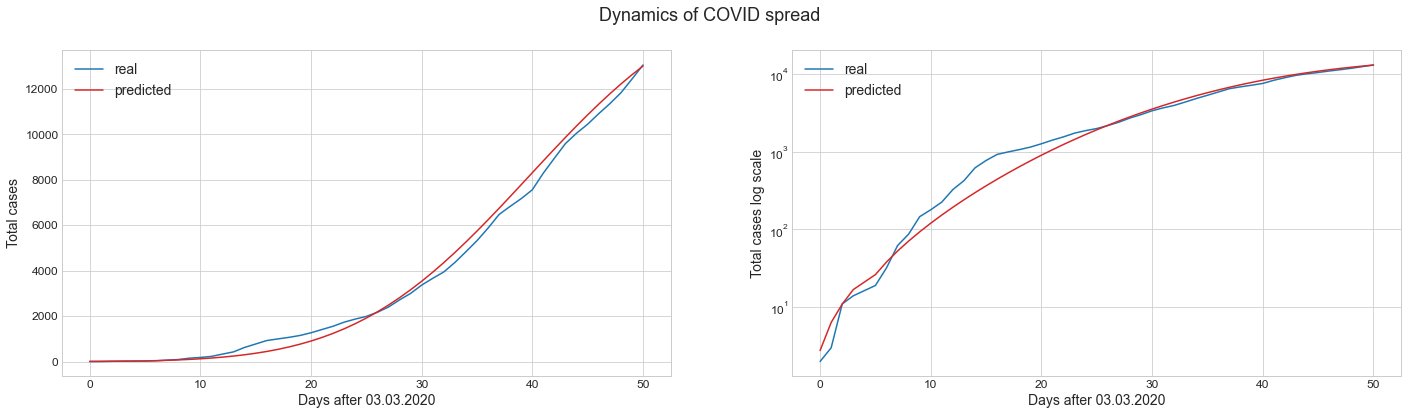

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

#### 4.2. Поиск апостериорного распределение параметров этой модели для достаточно широкого априорного распределения.

In [81]:
w = new_cases_model.coef_

sigma_noise = np.sqrt(((np.log(x_train["new_cases"].values) - x_train_poly @ w) ** 2).mean())

**Априорное распределение параметров модели:**

In [83]:
w0_x = np.linspace(w[0]-w[0]/2, w[0]+w[0]/2, 50)
w1_y = np.linspace(w[1]-w[1]/2, w[1]+w[1]/2, 50)
w2_z = np.linspace(w[2]+w[2]/2, w[2]-w[2]/2, 50)


w0_xx, w1_yy, w2_zz = np.meshgrid(w0_x, w1_y, w2_z, indexing='ij')
pos = np.dstack((w0_xx, w1_yy, w2_zz))
priori = multivariate_normal(w, [[np.abs(w[0])/4, 0, 0], [0, np.abs(w[1])/4, 0], [0, 0, np.abs(w[2])/4]])

**Правдоподобие параметров модели:**

In [84]:
likehood = np.zeros(w0_xx.shape)
for x in range(w0_xx.shape[0]):
    for y in range(w0_xx.shape[1]):
        for z in range(w0_xx.shape[2]):
            likehood[x, y, z] = calculate_likehood_poly(x_train_poly, np.log(x_train["new_cases"]), np.array([w0_xx[x, y, z], w1_yy[x, y, z], w2_zz[x, y, z]]), sigma_noise)

In [85]:
pos = np.empty(w0_xx.shape + (3,))
pos[:, :, :, 0] = w0_xx
pos[:, :, :, 1] = w1_yy
pos[:, :, :, 2] = w2_zz

**Апостериорное распределение параметров модели:**

In [86]:
posterioiri_pdf = priori.pdf(pos)*likehood

**Параметры соответсвующие максимуму априорного распределения (MAP):**

In [87]:
map_x, map_y, map_z = np.unravel_index(posterioiri_pdf.argmax(), posterioiri_pdf.shape)
w_map = np.array([w0_xx[map_x, map_y, map_z], w1_yy[map_x, map_y, map_z], w2_zz[map_x, map_y, map_z]])

#### 4.3 Семплирование много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

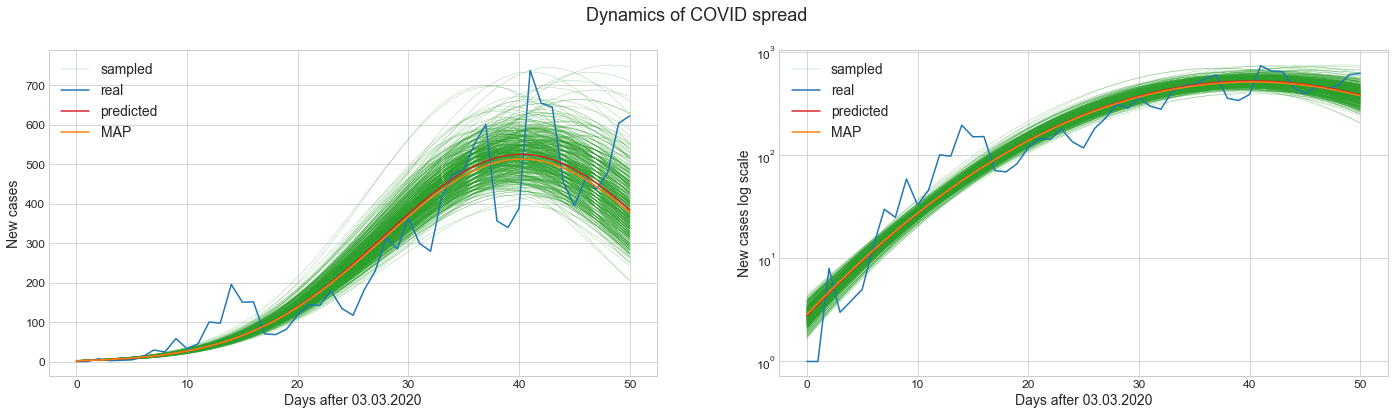

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", lw=0.2)
    ax2.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", label="sampled", lw=0.2)
ax2.plot(train_days,  np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])), color="tab:green", label="sampled", lw=0.2)

ax1.plot(train_days, x_train["new_cases"], color="tab:blue", label="real")
ax1.plot(train_days, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax1.plot(train_days, np.exp(x_train_poly @ w_map), color="tab:orange", label="MAP")
ax2.plot(train_days, x_train["new_cases"], color="tab:blue", label="real")
ax2.plot(train_days, x_train["new_cases_exp_pred"], color="tab:red", label="predicted")
ax2.plot(train_days, np.exp(x_train_poly @ w_map), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("New cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("New cases log scale")
ax2.set_yscale("log")
ax2.legend()

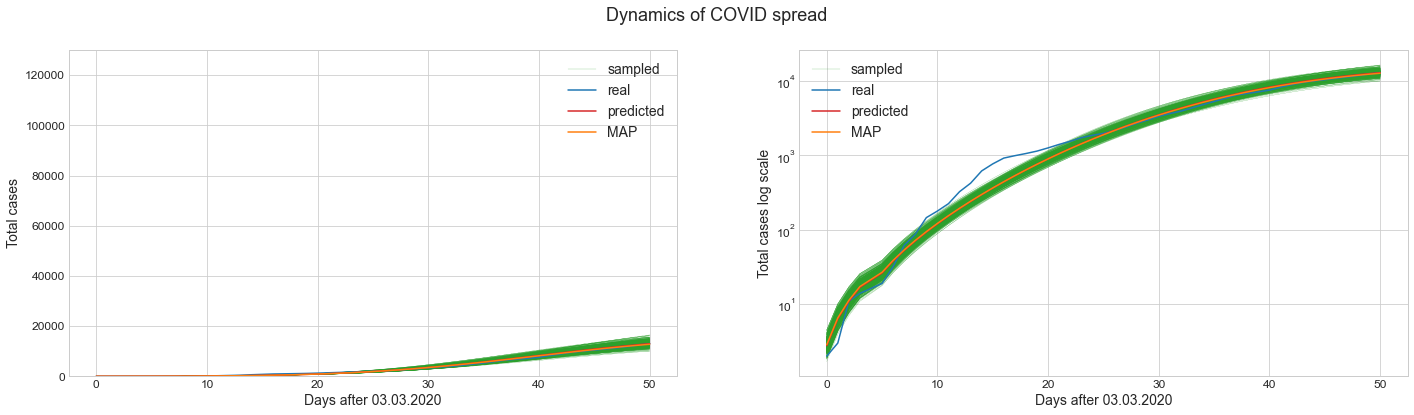

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)
    ax2.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)
ax2.plot(train_days,  np.cumsum(np.exp(x_train_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)

ax1.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax1.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax1.plot(train_days, np.cumsum(np.exp(x_train_poly @ w_map)), color="tab:orange", label="MAP")
ax2.plot(train_days, x_train["total_cases"], color="tab:blue", label="real")
ax2.plot(train_days, np.cumsum(x_train["new_cases_exp_pred"]), color="tab:red", label="predicted")
ax2.plot(train_days, np.cumsum(np.exp(x_train_poly @ w_map)), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.set_ylim(0, 130000)
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

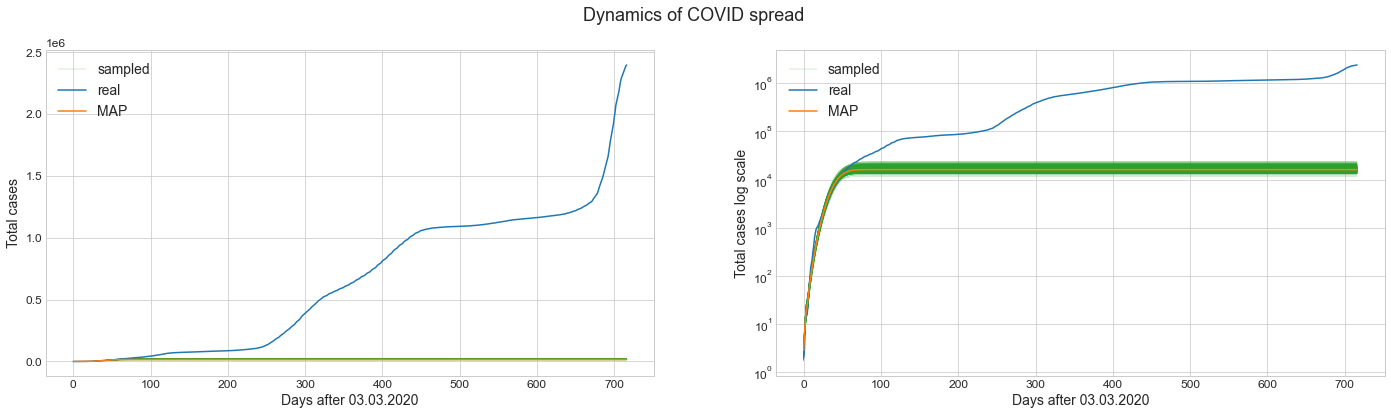

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for _ in range(500):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    ax1.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)
    ax2.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", lw=0.2)

sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
ax1.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)
ax2.plot(days,  np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]]))), color="tab:green", label="sampled", lw=0.2)

ax1.plot(days, data["total_cases"], color="tab:blue", label="real")
ax1.plot(days, np.cumsum(np.exp(days_poly @ w_map)), color="tab:orange", label="MAP")
ax2.plot(days, data["total_cases"], color="tab:blue", label="real")
ax2.plot(days, np.cumsum(np.exp(days_poly @ w_map)), color="tab:orange", label="MAP")

fig.suptitle("Dynamics of COVID spread")
ax1.set_xlabel("Days after 03.03.2020")
ax1.set_ylabel("Total cases")
ax1.legend()
ax2.set_xlabel("Days after 03.03.2020")
ax2.set_ylabel("Total cases log scale")
ax2.set_yscale("log")
ax2.legend()

**Предсказательные распределения:**

Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:
    на 01.05.2020: 15220.813731171755
    на 01.07.2020: 16054.0335992785
    на 01.09.2020: 16054.348109220795

Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:
    на 01.05.2020: 15502.308568722634
    на 01.07.2020: 16353.683431689253
    на 01.09.2020: 16353.743100333659



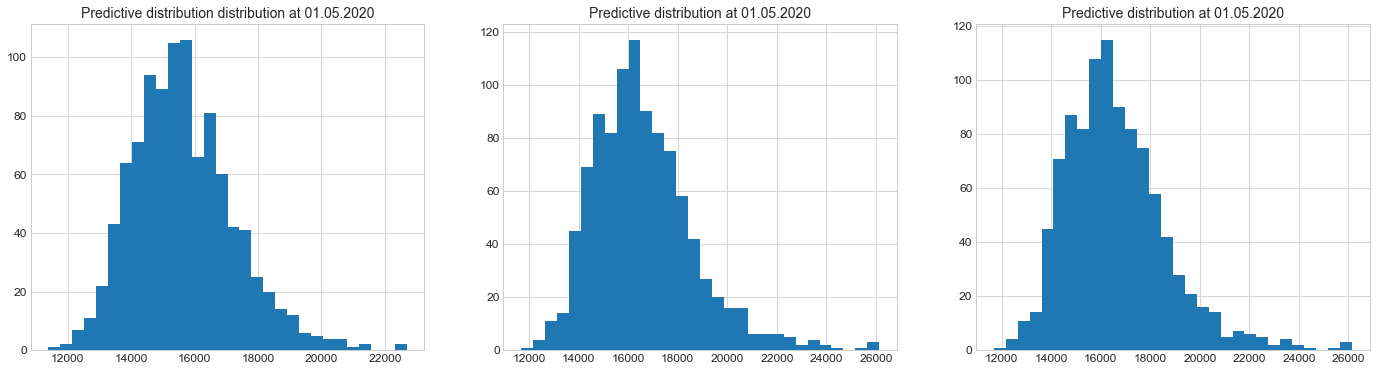

In [91]:
n_sampels = 1000
posterior_samples = np.ones([n_sampels, data.shape[0]])

for i in range(n_sampels):
    sample_x, sample_y, sample_z = np.unravel_index(np.random.choice(np.arange(posterioiri_pdf.flatten().shape[0]), p = posterioiri_pdf.flatten()/posterioiri_pdf.sum()), posterioiri_pdf.shape)
    posterior_samples[i] = np.cumsum(np.exp(days_poly @ np.array([w0_xx[sample_x, sample_y, sample_z], w1_yy[sample_x, sample_y, sample_z], w2_zz[sample_x, sample_y, sample_z]])))


fig, ax = plt.subplots(1, 3)

ax[0].hist(posterior_samples[:, may_day], bins=30)
ax[0].set_title("Predictive distribution distribution at 01.05.2020")


ax[1].hist(posterior_samples[:, june_day], bins=30)
ax[1].set_title("Predictive distribution at 01.05.2020")

ax[2].hist(posterior_samples[:, sep_day], bins=30)
ax[2].set_title("Predictive distribution at 01.05.2020")

total_cases_map = np.cumsum(np.exp(days_poly @ w_map))
print(f"Общее число заболевших при использовании параметров модели полyченных через максимизацию апостериорного распределения:\n\
    на 01.05.2020: {total_cases_map[may_day]}\n\
    на 01.07.2020: {total_cases_map[june_day]}\n\
    на 01.09.2020: {total_cases_map[sep_day]}\n")

print(f"Общее число заболевших при использовании параметров модели полyченных как медиана предсказательного распределения:\n\
    на 01.05.2020: {np.median(posterior_samples[:, may_day])}\n\
    на 01.07.2020: {np.median(posterior_samples[:, june_day])}\n\
    на 01.09.2020: {np.median(posterior_samples[:, sep_day])}\n")

In [92]:
last_date = data["date"].iloc[-1].date()
last_date_cases = data["total_cases"].iloc[-1]
print(f"Прогноз общего числа заболевших на {last_date}:\n\
    Оптимистичный: {int(np.quantile(posterior_samples[:, -1], 0.1))}\n\
    Пессимистичный: {int(np.quantile(posterior_samples[:, -1], 0.9))}\n\
    Крайне пессимистичный: {int(np.quantile(posterior_samples[:, -1], 0.98))}\n\
    Реальные данные: {int(last_date_cases)}\n")

Прогноз общего числа заболевших на 2022-02-11:
    Оптимистичный: 14247
    Пессимистичный: 19029
    Крайне пессимистичный: 22065
    Реальные данные: 2397330



**Вывод:** Видно, что из-за наличия выраженной волны в первые 50 дней, точка насыщения начинается намного раньше, и крайне плохо описывает последующую динамику развития эпидемии.

### 5. Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?
1. Разобрался на актуальном датасете с Байесовским выводом. (одно дело игрушечные примеры с монеткой или кубиком, другое дело когда сам всё на практике реализуешь);
2. Одназначно можно сделать вывод, что экспонентой описывать развитие эпидемии плохая идея, в идеальном мире для этого должа подходить гауссиана, но как мы видим на практике, даже гауссиана является слабой моделью из-за наличия всё более мощных волн роста новых случаев коронавируса.
3. На счёт карантина, я хотел сделать выводы о введении карантина, сравнив страну которая не вводила карантины (Швеция) и странну которая карантины вводила (Россия), но по представленной динамике сложно сделать какие-то выводы. Чисто логически, принятие решения о введении карантина можно делать сравнивая наличие/отсутсвие и скорость затухания волн числа новых случае коронавируса в страннах, которые вводили карантин и странах, которые не вводили карантин. 